# Nancy Grace Roman Space Telescope<br>SIRS Reference Correction in Python

Bernard J. Rauscher<br>
NASA Goddard Space Flight Center

12 April 2021

e-Mail: Bernard.J.Rauscher@nasa.gov

The purpose of this notebook is to show how to apply SIRS reference correction using python-3 if a calibration files is available. 

We originally wrote SIRS in Julia because computing $\mathbf{\alpha}$ and $\mathbf{\beta}$ from training data can be time consuming. However, once the frequency dependent weight vectors are known, using them to make a reference correction is fairly quick. This notebook shows how to reference correct one up-the-ramp sampled exposure.

Julia Data Format (JLD) is a dialect of HDF5. For purposes of reading the calibration files into python, they can be treated as HDF5.

In [1]:
# Standard packages
import numpy as np
from astropy.io import fits

# Load SIRS python package
import sirspy

In [2]:
# Here is the SIRS calibration file for H4RG S/N 20663
sirs_file = '/att/gpfsfs/briskfs01/ppl/brausche/roman_caldir/SIRS_Results_2/'+\
                '2021-03-19T12:18:18_HyC_20663_95.0K_1.0V_SIRS.jld'

# Here is a sampled up-the-ramp dark from the same H4RG and test set
data_file = '/att/gpfsfs/briskfs01/project/wfirst/H4RG/HyC/'+\
                '20663_20666_20669_20496/20190914_95k_1p1m0p1_noise_20663_005.fits'

We now have everything that we need to reference correct an exposure from H4RG 20663. The following duplicates functionality that is built into the SIRS package in Julia. The intent here is to explain how to do it in python. This can serve as the basis for more customized python code.

In [3]:
# Instantiate the SIRS
sirs = sirspy.SIRS(sirs_file)

Begin by duplicating Fig. 3, panels a) and c) from the JATIS article. This demonstrates that we have correctly imported $\mathbf{\alpha}$ and $\mathbf{\beta}$. 

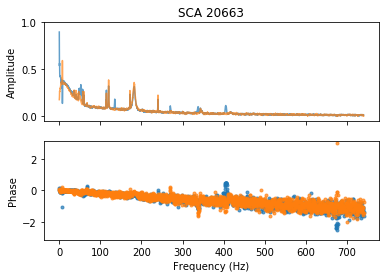

In [4]:
plt = sirs.plot(15)
plt.show()

Read in some data and reference correct. Do both SIRS and rowsonly for comparison.

In [5]:
# The files on ADAPT are 4-dimensional. The data
# are in hdu1 and the 0th dimension is empty
with fits.open(data_file) as hdul:
    D1 = -np.float64(hdul[1].data[0]) # Integrate up
    D2 = D1.copy()
    
# Legacy reference correct D1. Just hardcode it
# since we know what the file is (H4RG; 60 frames)
for z in np.arange(60):
    for op in np.arange(32):
        x0 = op * sirs.xsize
        x1 = x0 + sirs.xsize
        ref = np.mean(np.sort(D1[z,4093:4095,x0:x1].flatten())\
                          [sirs.discard:-sirs.discard])
        D1[z,:,x0:x1] -= ref
        
# SIRS reference correct D2
sirs.refcor(D2)

To show the effect, fit and save slope images.

In [6]:
# Make a Legendre basis matrix to do fitting. Hard
# code this since we know that the file has 60 frames
# and we only want to fit for the offset and slope.
L = np.zeros((60,2), dtype=np.float)
x = np.arange(-1,+1+2/59,2/59) # x-values for Legendre polynomials
L[:,0] = np.polynomial.legendre.legval(x,[1,0]) # Offset
L[:,1] = np.polynomial.legendre.legval(x,[0,1]) # Slope
pinv_L = np.linalg.pinv(L) # This does the actual fitting

In [7]:
# Fit without reference correction
fits.PrimaryHDU(np.einsum('ij,jkl',pinv_L,D1)).writeto('nocor.fits', overwrite=True)

In [8]:
# Fit with SIRS correction
fits.PrimaryHDU(np.einsum('ij,jkl',pinv_L,D2)).writeto('sirs.fits', overwrite=True)

If the results files are examined in a FITS viewer such as SAOImage DS9, it is clear that the SIRS processed file has less banding.